<a href="https://colab.research.google.com/github/ToniRV/MIT_6.862_Applied_Machine_Learning/blob/master/MIT_6_036_HW07_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT 6.036 Fall 2019: Homework 7 - PyTorch

This colab notebook provides code and a framework for homework 7. You can work out your solutions here, then submit your results back on the homework page when ready.

**Note**: You can go to `File > Save a copy in Drive...` to save your own copy of this notebook for editing.

## Setup

First, download the code distribution for this homework that contains test cases and helper functions. Run the next code block to download and import the code for this lab.

In [2]:
!rm -rf code_for_hw7 data
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw07/code_for_hw7.zip
!unzip code_for_hw7.zip
!mv code_for_hw7/* .

Archive:  code_for_hw7.zip
   creating: code_for_hw7/
  inflating: code_for_hw7/utils_hw7.py  
  inflating: code_for_hw7/code_for_hw7_pytorch.py  
  inflating: code_for_hw7/code_for_hw7.py  
  inflating: code_for_hw7/modules_disp.py  
   creating: code_for_hw7/data/
  inflating: code_for_hw7/data/data2_validate.csv  
  inflating: code_for_hw7/data/dataXor_train.csv  
  inflating: code_for_hw7/data/data1_train.csv  
  inflating: code_for_hw7/data/data4_train.csv  
  inflating: code_for_hw7/data/data4_validate.csv  
  inflating: code_for_hw7/data/data3class_train.csv  
  inflating: code_for_hw7/data/data1_validate.csv  
  inflating: code_for_hw7/data/data3_train.csv  
  inflating: code_for_hw7/data/data2_train.csv  
  inflating: code_for_hw7/data/data3_validate.csv  
  inflating: code_for_hw7/expected_results.py  


# 3) 2D Datasets

For the 2D datasets, we have provided the following function:

>```run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)```

where:

* `data_name` is a string, such as '1', '2', etc. 
* `layers` is a list of torch.nn layer definitions for a Sequential model, e.g.
> ```[Linear(in_features=2, out_features=classes, bias=True), Softmax(dim=-1)]```
* `epochs` is an integer indicating how many times to go through the data in training 
* `split` is a fraction of the training data to use for validation if a validation set is not defined 
* `display` whether to display result plots 
* `verbose` whether to print loss and accuracy (percent correctly labeled) each epoch 
* `trials` is an integer indicating how many times to perform the training and testing 

The two-class datasets have `data_name`s: `'1'`,`'2'`,`'3'`,`'4'`.

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

`0: (), 1: (10), 2: (100), 3: (10, 10), 4: (100, 100)`

You may find the `archs` function below to be helpful here. Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

## Helper Functions

The following functions will train a neural network in PyTorch. You do not need to edit them but please try to go through them. There is a **Playground** section below that shows how to run these methods for the homework.

In [0]:
from utils_hw7 import plot_heat, get_data_loader, model_fit, model_evaluate, run_pytorch, dataset_paths

In [0]:
import numpy as np
import itertools
import math as m
from matplotlib import pyplot as plt

In [0]:
import torch
from torch.nn import Linear, ReLU, Softmax, Sequential, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


######################################################################
# Problem 3 - 2D data
######################################################################

def archs(classes):
    return {0: [Linear(in_features=2, out_features=classes, bias=True),
             Softmax(dim=-1)],
            
            1: [Linear(in_features=2, out_features=10, bias=True),
             ReLU(),
             Linear(in_features=10, out_features=classes, bias=True),
             Softmax(dim=-1)],

            2: [Linear(in_features=2, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=classes, bias=True),
             Softmax(dim=-1)],
            
            3: [Linear(in_features=2, out_features=10, bias=True),
             ReLU(),
             Linear(in_features=10, out_features=10, bias=True),
             ReLU(),
             Linear(in_features=10, out_features=classes, bias=True),
             Softmax(dim=-1)],

            4: [Linear(in_features=2, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=100, bias=True),
             ReLU(),
             Linear(in_features=100, out_features=classes, bias=True),
             Softmax(dim=-1)]
           }



In [0]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention.
Please try to go through it.
"""

def call_model(mode, model, data_iter, optimizer, criterion):
    epoch_loss = []
    hits = []
    items = []
    
    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch.X, batch.y

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X)
            batch_loss = criterion(y_hat, y.long())

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            epoch_loss.append(batch_loss.item())
            hits.append((y_hat.argmax(1) == y).sum())
            items.append(X.shape[0])

        loss = np.sum(epoch_loss)/np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

In [0]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention because
you'll be running (but not modifying) this function for this
homework.
Please try to go through it.
"""

def run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True,
                   verbose=True, trials=1, batch_size=32):
    print('Pytorch FC: dataset=', data_name)
    (train_dataset_path, val_dataset_path, test_dataset_path) = dataset_paths(data_name)
    # Load the datasets
    train_iter, num_classes = get_data_loader(train_dataset_path, batch_size)
    val_iter, num_classes = get_data_loader(val_dataset_path, batch_size)
    test_iter, num_classes = get_data_loader(test_dataset_path, batch_size)
    
    if val_iter is None:
        # Use split
        print("Use split", train_iter)
        assert split > 0, '`split` must be > 0'
        train_iter, val_iter,  num_classes = get_data_loader(train_dataset_path, batch_size, split)

    val_acc, test_acc = 0, 0
    X_train = torch.cat([batch.X for batch in train_iter], 0)
    y_train = torch.cat([batch.y for batch in train_iter], 0)
    
    for trial in range(trials):
        trial_history = {'epoch_loss': [], 'epoch_val_loss': [],
               'epoch_acc': [], 'epoch_val_acc': []}
    
        if verbose: print("\n")
        print(f'# Trial {trial}')
        
        # Run the model
        model, vacc, tacc, = run_pytorch(train_iter, val_iter, test_iter, 
                                         layers, epochs, split=split,
                                         verbose=verbose, history=trial_history)

        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y_train, model)
            plt.title('Training data')
            plt.show()
            if test_iter is not None:
                # plot classifier landscape on testing data
                X_test = torch.cat([batch.X for batch in test_iter], 0)
                y_test = torch.cat([batch.y for batch in test_iter], 0)
                plot_heat(X_test, y_test, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_loss'], label='epoch_train_loss')
            plt.plot(range(epochs), trial_history['epoch_val_loss'], label='epoch_val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.legend()
            plt.show()
            # Plot epoch accuracy
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_acc'], label='epoch_train_acc')
            plt.plot(range(epochs), trial_history['epoch_val_acc'], label='epoch_val_acc')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
        
   
    return X_train, y_train, model

## 3G)

In [0]:
points = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])

deterministic = True
if deterministic:
  torch.manual_seed(10)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(10)

"""
HERE YOUR CODE!!
"""
pass

# Playground

Pytorch FC: dataset= 2
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}
# Trial 0


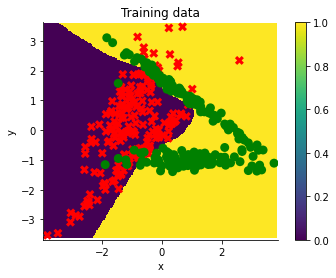

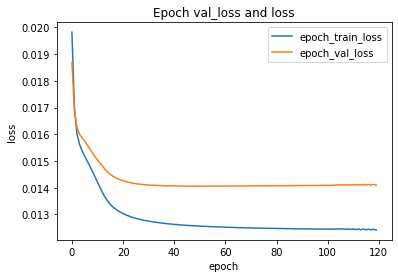

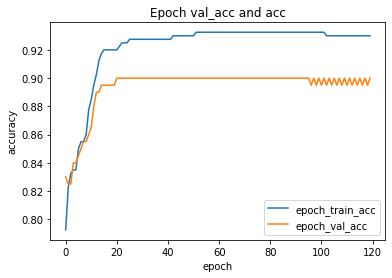


Avg. validation accuracy:0.8938333333333335


In [48]:
_ = run_pytorch_2d("2", archs(2)[4], 120, display=True, verbose=False, trials=1)

In [49]:
_ = run_pytorch_2d("3class",archs(3)[0], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf81f44e0>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.4294124999999999


In [50]:
_ = run_pytorch_2d("3class",archs(3)[0], 10, split=.5, display=False, verbose=False, trials=20)


Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf81f4588>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.45755


In [51]:

_ = run_pytorch_2d("3class",archs(3)[1], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf81f40f0>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.5825375


In [52]:

_ = run_pytorch_2d("3class",archs(3)[2], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf81f4240>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.8753125


In [53]:

_ = run_pytorch_2d("3class",archs(3)[3], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf52aff60>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.5737125


In [54]:

_ = run_pytorch_2d("3class",archs(3)[4], 10, split=.5, display=False, verbose=False, trials=20)

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf52aff60>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0
# Trial 1
# Trial 2
# Trial 3
# Trial 4
# Trial 5
# Trial 6
# Trial 7
# Trial 8
# Trial 9
# Trial 10
# Trial 11
# Trial 12
# Trial 13
# Trial 14
# Trial 15
# Trial 16
# Trial 17
# Trial 18
# Trial 19

Avg. validation accuracy:0.9419125000000002


In [67]:
deterministic = True
if deterministic:
  torch.manual_seed(10)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(10)

# Train
linear_layer = archs(3)[0]
X_train, y_train, model = run_pytorch_2d("3class",linear_layer, 10, split=.5,
                                         display=False, verbose=False, trials=1)

# Get data
x = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])

# Get the weights after training
W = linear_layer[0].weight.data.numpy()
W0 = linear_layer[0].bias.data.numpy()


# Automated
print('Automated calculation:')
model.eval()
torch_x = torch.from_numpy(x).float()
output = model(torch_x)
cpu_pred = output.cpu()
result = cpu_pred.data.numpy()
print(result.tolist())
print(np.argmax(result, axis=1).tolist())

# Manually
print('Manual calculation:')
z = np.array([np.dot(W, point.T) + W0 for point in x])
print(z.tolist())
print(np.argmax(z, axis=1).tolist())

Pytorch FC: dataset= 3class
Loading X torch.Size([800, 2]) y torch.Size([800]) classes {0.0, 1.0, 2.0}
Use split <torch.utils.data.dataloader.DataLoader object at 0x7feaf52d8160>
Using validation split
train_size 400 val_size 400
Loading train X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
Loading val X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0, 2.0}
# Trial 0

Avg. validation accuracy:0.46875
Automated calculation:
[[0.2655330002307892, 0.3895283043384552, 0.344938725233078], [0.28583940863609314, 0.4857136011123657, 0.22844697535037994], [0.9892951846122742, 0.010704157873988152, 5.500781981027103e-07], [0.1376701146364212, 0.34191375970840454, 0.5204161405563354], [0.43807297945022583, 0.4085352122783661, 0.15339183807373047], [0.1230471208691597, 0.28394195437431335, 0.5930109024047852], [0.15064726769924164, 0.40267714858055115, 0.4466756582260132], [0.4356034994125366, 0.47055676579475403, 0.09383978694677353]]
[1, 1, 0, 2, 0, 2, 2, 1]
Manual 